<a href="https://colab.research.google.com/github/danielriosgarza/sharedColabBooks/blob/main/dynamicFBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Task: dynamic FBA

- Study the code below to understand how one can make FBA dynamic

- Make modifications to explore the three conditions (rich media, only glucose, and no glucose)

- Perform parameter sweeps to understand the effects of each class of parameters (e.g. yield, monod constants)

- How is the community different in a batch compared to when there is a flow-rate? How is the community impacted by the flow-rate?

- How is the community different when one removes the diauxic shift (in the growth rate function of the butyrate producer)?

- How is the H2/CO2 cross-feeding impacted by the yield and Monod constants?


In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/gemCourse')
!ls "/content/drive/My Drive/gemCourse/sbmlModels"

acetogen_full_model.xml  butyrate_producer_full_model.xml  sugar_fermenter_full_model.xml
acetogen_toy_model.xml	 butyrate_producer_toy_model.xml   sugar_fermenter_toy_model.xml




```
# This is formatted as code
```

**step 1**: import packages and load models

In [ ]:
#!pip install cobra
import os
import cobra
import numpy as np
from scipy.integrate import solve_ivp as solver
import matplotlib.pyplot as plt
plt.style.available
#plt.style.use('"seaborn-v0_8"')

modelFolder = '/content/drive/My Drive/gemCourse/sbmlModels'


model_ac = cobra.io.read_sbml_model(os.path.join(modelFolder,'acetogen_toy_model.xml' ))
model_sf = cobra.io.read_sbml_model(os.path.join(modelFolder,'sugar_fermenter_toy_model.xml' ))
model_bp = cobra.io.read_sbml_model(os.path.join(modelFolder,'butyrate_producer_toy_model.xml' ))


**step 2**: define parameters and initial states

**Parameters**

| parameter | variable | default value |
| --------- | -------- | ------------- |
| acetogen glucose Monod K | ac_glucose_k | 1.0 |
| acetogen glucose yield | ac_glucose_y | 1.0 |
| acetogen formate Monod K | ac_for_k | 10.0 |
| acetogen formate yield | ac_for_y | 1.0 |
| acetogen CO2 Monod K | ac_co2_k | 1.0 |
| acetogen CO2 yield | ac_co2_y | 10.0 |
| acetogen H2 Monod K | ac_h2_k | 10.0 |
| acetogen H2 yield | ac_h2_y | 10.0 |
| acetogen acetate yield | ac_ac_y | -1.0 |
| acetogen lactate yield | ac_lac_y | -1.0 |
| sugarF glucose Monod K | sf_glucose_k | 1.0 |
| sugarF glucose yield | sf_glucose_y | 1.0 |
| sugarF succinate yield | sf_succ_y | -1.0 |
| sugarF formate yield | sf_for_y | -1.0 |
| sugarF lactate yield | sf_lac_y | -1.0 |
| sugarF acetate yield | sf_ac_y | -1.0 |
| butyrateP glucose Monod K | bp_glucose_k | 1.0 |
| butyrateP glucose yield | bp_glucose_y | 1.0 |
| butyrateP lactate consumpation Monod K | bp_lactate_c_k | 1.0 |
| butyrateP lactate consumption yield | bp_lactate_c_y | 1.0 |
| butyrateP lactate production yield | bp_lactate_p_y | -1.0 |
| butyrateP acetate consumpation Monod K | bp_acetate_c_k | 1.0 |
| butyrateP acetate consumption yield | bp_acetate_c_y | 1.0 |
| butyrateP acetate production yield | bp_acetate_p_y | -1.0 |
| butyrateP CO2 production yield | bp_co2_y | -1.0 |
| butyrateP H2 production yield | bp_h2_y | -1.0 |
| butyrateP butyrate production yield | bp_butyrate_y | -1.0 |
| flow rate | flow_rate | 0.1 |


**States**

| state | position | default value |
| ----- | -------- | ------------- |
|glucose concentration | 0 | 10 |
|formate concentration | 1 | 0 |
|CO2 concentration | 2 | 0 |
|H2 concentration | 3 | 0 |
|acetate concentration | 4 | 0 |
|lactate concentration | 5 | 0 |
|succinate concentration | 6 | 0 |
|butyrate concentration | 7 | 0 |
|acetogen biomass | 8 | 0.1 |
|sugarF biomass | 9 | 0.1 |
|butyrateP biomass | 10 | 0.1 |



In [ ]:
parameters = {'ac_glucose_k' : 1.0,
              'ac_glucose_y' : 1.0,
              'ac_for_k' : 10.0,
              'ac_for_y' : 1.00,
              'ac_co2_k' : 1.0,
              'ac_co2_y' : 10.00,
              'ac_h2_k' : 10.0,
              'ac_h2_y' : 1.00,
              'ac_ac_y':-1.0,
              'ac_lac_y':-1.0,
              'sf_glucose_k':1.0,
              'sf_glucose_y':1.0,
              'sf_succ_y':-1.0,
              'sf_for_y':-1.0,
              'sf_lac_y':-1.0,
              'sf_ac_y':-1.0,
              'bp_glucose_k':1.0,
              'bp_glucose_y':1.0,
              'bp_lactate_c_k':1.0,
              'bp_lactate_c_y':1.00,
              'bp_lactate_p_y': -1,
              'bp_acetate_c_k':1.0,
              'bp_acetate_c_y':1.0,
              'bp_acetate_p_y':-1,
              'bp_co2_y': -1,
              'bp_h2_y':-1,
              'bp_butyrate_y':-1,
              'flow_rate':0.1}

initial_states = np.array([10, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1])
#glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0


In [ ]:
import ipywidgets as widgets
from IPython.display import display
from collections import defaultdict
import numpy as np
import functools

# Parameters dictionary
parameters = {'ac_glucose_k' : 1.0,
              'ac_glucose_y' : 1.0,
              'ac_for_k' : 10.0,
              'ac_for_y' : 1.00,
              'ac_co2_k' : 1.0,
              'ac_co2_y' : 10.00,
              'ac_h2_k' : 10.0,
              'ac_h2_y' : 1.00,
              'ac_ac_y':-1.0,
              'ac_lac_y':-1.0,
              'sf_glucose_k':1.0,
              'sf_glucose_y':1.0,
              'sf_succ_y':-1.0,
              'sf_for_y':-1.0,
              'sf_lac_y':-1.0,
              'sf_ac_y':-1.0,
              'bp_glucose_k':1.0,
              'bp_glucose_y':1.0,
              'bp_lactate_c_k':1.0,
              'bp_lactate_c_y':1.00,
              'bp_lactate_p_y': -1,
              'bp_acetate_c_k':1.0,
              'bp_acetate_c_y':1.0,
              'bp_acetate_p_y':-1,
              'bp_co2_y': -1,
              'bp_h2_y':-1,
              'bp_butyrate_y':-1,
              'flow_rate':0.1}

# Initial states names and default values
initial_states_names = [
    'glc_S0', 'for_S0', 'co2_S0', 'H2_S0', 'acetate_S0',
    'lac_S0', 'succ_S0', 'but_S0', 'ac_X0', 'sf_X0', 'bp_X0'
]

initial_states_defaults = {
    'glc_S0': 10.0,
    'for_S0': 0.0,
    'co2_S0': 0.0,
    'H2_S0': 0.0,
    'acetate_S0': 0.0,
    'lac_S0': 0.0,
    'succ_S0': 0.0,
    'but_S0': 0.0,
    'ac_X0': 0.1,
    'sf_X0': 0.1,
    'bp_X0': 0.1
}

# Function to update parameter value
def on_value_change(change, key):
    parameters[key] = change['new']

# Function to create parameter widgets
def create_parameter_widgets(parameters):
    parameter_widgets = {}
    for key, value in parameters.items():
        widget = widgets.FloatText(
            value=value,
            description=key,
            layout=widgets.Layout(width='300px'),
            style={'description_width': '150px'}
        )
        handler = functools.partial(on_value_change, key=key)
        widget.observe(handler, names='value')
        parameter_widgets[key] = widget
    return parameter_widgets

# Function to update initial state value
def on_initial_state_change(change, key):
    initial_states_defaults[key] = change['new']

# Function to create initial state widgets
def create_initial_state_widgets(initial_states_defaults):
    initial_state_widgets = {}
    for key, value in initial_states_defaults.items():
        widget = widgets.FloatText(
            value=value,
            description=key,
            layout=widgets.Layout(width='300px'),
            style={'description_width': '150px'}
        )
        handler = functools.partial(on_initial_state_change, key=key)
        widget.observe(handler, names='value')
        initial_state_widgets[key] = widget
    return initial_state_widgets

# Function to group parameters by prefix
def group_parameters_by_prefix(parameters):
    grouped_params = defaultdict(dict)
    for key, value in parameters.items():
        if '_' in key:
            prefix = key.split('_')[0]
        else:
            prefix = 'Other'
        grouped_params[prefix][key] = value
    return grouped_params

# Group the parameters
grouped_parameters = group_parameters_by_prefix(parameters)

# List to hold accordion contents
accordion_children = []
accordion_titles = []

# Create widgets for each group
for group_name, group_params in grouped_parameters.items():
    group_widgets = create_parameter_widgets(group_params)
    group_widget_list = [group_widgets[key] for key in sorted(group_widgets.keys())]
    group_box = widgets.VBox(group_widget_list)
    accordion_children.append(group_box)
    accordion_titles.append(group_name)

# Create the accordion widget for parameters
parameters_accordion = widgets.Accordion(children=accordion_children)

# Set the titles for each accordion tab
for idx, title in enumerate(accordion_titles):
    parameters_accordion.set_title(idx, title)

# Create initial state widgets
initial_state_widgets = create_initial_state_widgets(initial_states_defaults)
initial_state_widget_list = [initial_state_widgets[key] for key in initial_states_names]
initial_states_box = widgets.VBox(initial_state_widget_list)

# Create an accordion to hold the initial states
initial_states_accordion = widgets.Accordion(children=[initial_states_box])
initial_states_accordion.set_title(0, 'Initial States')

# Display the parameter widgets and initial state widgets
display(parameters_accordion)
display(initial_states_accordion)


def get_initial_states_array(initial_states_defaults, initial_states_names):
    initial_states = []
    for name in initial_states_names:
        value = initial_states_defaults[name]
        initial_states.append(value)
    return np.array(initial_states)


Accordion(children=(VBox(children=(FloatText(value=-1.0, description='ac_ac_y', layout=Layout(width='300px'), …

Accordion(children=(VBox(children=(FloatText(value=10.0, description='glc_S0', layout=Layout(width='300px'), s…

In [ ]:
print("Updated Parameters:")
for key in sorted(parameters.keys()):
    print(f"{key}: {parameters[key]}")


# Retrieve the updated initial_states array
initial_states = get_initial_states_array(initial_states_defaults, initial_states_names)

print("\nUpdated Initial States Array:")
print(initial_states)


Updated Parameters:
ac_ac_y: -1.0
ac_co2_k: 1.0
ac_co2_y: 10.0
ac_for_k: 10.0
ac_for_y: 1.0
ac_glucose_k: 1.0
ac_glucose_y: 1.0
ac_h2_k: 10.0
ac_h2_y: 1.0
ac_lac_y: -1.0
bp_acetate_c_k: 1.0
bp_acetate_c_y: 1.0
bp_acetate_p_y: -1
bp_butyrate_y: -1
bp_co2_y: -1
bp_glucose_k: 1.0
bp_glucose_y: 1.0
bp_h2_y: -1
bp_lactate_c_k: 1.0
bp_lactate_c_y: 1.0
bp_lactate_p_y: -1
flow_rate: 0.01
sf_ac_y: -1.0
sf_for_y: -1.0
sf_glucose_k: 1.0
sf_glucose_y: 1.0
sf_lac_y: -1.0
sf_succ_y: -1.0

Updated Initial States Array:
[10.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1]


**step 3**: write growth rate functions ($\mu$) for each bacteria

In [ ]:
def muAc(concentration_vec):
    '''
    growth rate function for the acetogen

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_formate
    consumed_co2
    consumed_h2
    produced_acetate
    produced_lactate
    objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['ac_glucose_k']))*(concentration_vec[0]>0)
    #(concentration_vec[0]>0) avoids negatives

    consumable_formate = (concentration_vec[1]/(concentration_vec[1]+parameters['ac_for_k']))*(concentration_vec[1]>0)

    consumable_co2 = (concentration_vec[2])/(concentration_vec[2]+parameters['ac_co2_k'])*(concentration_vec[2]>0)

    consumable_h2 = (concentration_vec[3])/(concentration_vec[3]+parameters['ac_h2_k'])*(concentration_vec[3]>0)

    #set the lower bounds to the consumable amounts

    model_ac.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    model_ac.reactions.EX_cpd00047_e.lower_bound = -1*consumable_formate
    model_ac.reactions.EX_cpd00011_e.lower_bound = -1*consumable_co2
    model_ac.reactions.EX_cpd11640_e.lower_bound = -1*consumable_h2

    #optimize with these consumable amounts as constraints

    sol_ac = model_ac.optimize()

    #get what was effectively consumed/produces
    consumed_glucose = max(0, model_ac.reactions.EX_cpd00027_e.flux*-1)
    consumed_formate = max(0, model_ac.reactions.EX_cpd00047_e.flux*-1)
    consumed_co2 = max(0, model_ac.reactions.EX_cpd00011_e.flux*-1)
    consumed_h2 = max(0, model_ac.reactions.EX_cpd11640_e.flux*-1)

    produced_acetate = max(0, model_ac.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, model_ac.reactions.EX_cpd00159_e.flux)

    return (consumed_glucose,
            consumed_formate,
            consumed_co2,
            consumed_h2,
            produced_acetate,
            produced_lactate,
            sol_ac.objective_value #the biomass given the consumable amounts
            )


def muSf(concentration_vec):
    '''

    Growth rate function for the sugarF

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    produced_acetate
    produced_lactate
    produced_succinate
    produced_formate
    objective_value

    '''



    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['sf_glucose_k']))*(concentration_vec[0]>0)

    model_sf.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose

    sol_sf = model_sf.optimize()

    consumed_glucose = max(0, model_sf.reactions.EX_cpd00027_e.flux*-1)

    produced_acetate = max(0, model_sf.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, model_sf.reactions.EX_cpd00159_e.flux)
    produced_succinate = max(0, model_sf.reactions.EX_cpd00036_e.flux)
    produced_formate = max(0, model_sf.reactions.EX_cpd00047_e.flux)

    return (consumed_glucose,
            produced_acetate,
            produced_lactate,
            produced_succinate,
            produced_formate,
            sol_sf.objective_value
            )


def muBP(concentration_vec):
    '''
    Growth rate for the butyrate producer

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_acetate
    consumed_lactate
    produced_acetate
    produced_lactate
    produced_co2
    produced_h2
    produced_butyrate
    sol_bp.objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['bp_glucose_k']))*(concentration_vec[0]>0)
    consumable_acetate = (concentration_vec[4]/(concentration_vec[4]+parameters['bp_acetate_c_k']))*(concentration_vec[4]>0)
    consumable_lactate = (concentration_vec[5]/(concentration_vec[5]+parameters['bp_lactate_c_k']))*(concentration_vec[5]>0)

    model_bp.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    model_bp.reactions.EX_cpd00029_e.lower_bound = -1*consumable_acetate
    model_bp.reactions.EX_cpd00159_e.lower_bound = -1*consumable_lactate


    sol_bp = model_bp.optimize()
    consumed_glucose = max(0, model_bp.reactions.EX_cpd00027_e.flux*-1)
    consumed_acetate = 0
    produced_acetate = 0
    consumed_lactate = 0
    produced_lactate = 0

    #acetate was consumed instead of produced
    if model_bp.reactions.EX_cpd00029_e.flux<0:
        consumed_acetate = model_bp.reactions.EX_cpd00029_e.flux*-1

    #lactate was consumed instead of produced
    if model_bp.reactions.EX_cpd00159_e.flux<0:
        consumed_lactate = model_bp.reactions.EX_cpd00159_e.flux*-1


    #acetate was produced
    if model_bp.reactions.EX_cpd00029_e.flux>0:
        produced_acetate = model_bp.reactions.EX_cpd00029_e.flux

    #lactate was produced
    if model_bp.reactions.EX_cpd00159_e.flux>0:
        produced_lactate = model_bp.reactions.EX_cpd00159_e.flux


    produced_co2 = max(0, model_bp.reactions.EX_cpd00011_e.flux)
    produced_h2 = max(0, model_bp.reactions.EX_cpd11640_e.flux)
    produced_butyrate = max(0, model_bp.reactions.EX_cpd00211_e.flux)

    return (consumed_glucose,
            consumed_acetate,
            consumed_lactate,
            produced_acetate,
            produced_lactate,
            produced_co2,
            produced_h2,
            produced_butyrate,
            sol_bp.objective_value
            )



**Step 4**: define the ordinary differential equation (ODE) that updates the states (see the table containing the 11 states above)

In [ ]:
def ode(t, states):

    '''
    ODE
    states:
        [glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0]
    '''

    #get the metabolite consumption/production and instantaneous growth rates
    mu_ac = muAc(states)
    mu_sf = muSf(states)
    mu_bp = muBP(states)

    #get the current biomasses
    pop_ac = states[8]
    pop_sf = states[9]
    pop_bp = states[10]

    #change in the acetogen biomass
    dAc = (pop_ac* mu_ac[-1])-parameters['flow_rate']*pop_ac

    #change in the sugarF biomass
    dSf = (pop_sf* mu_sf[-1]) - parameters['flow_rate']*pop_sf

    #change in the butyrateP biomass
    dBp = (pop_bp*mu_bp[-1])- parameters['flow_rate']*pop_bp

    #acetogen metabolite consumption/production
    ac_glc = -(mu_ac[0]/parameters['ac_glucose_y'])*pop_ac
    ac_for = -(mu_ac[1]/parameters['ac_for_y'])*pop_ac
    ac_co2 = -(mu_ac[2]/parameters['ac_co2_y'])*pop_ac
    ac_h2 = -(mu_ac[3]/parameters['ac_h2_y'])*pop_ac
    ac_ac = -(mu_ac[4]/parameters['ac_ac_y'])*pop_ac
    ac_lac = -(mu_ac[5]/parameters['ac_lac_y'])*pop_ac

    #sugarF metabolite consumption/production
    sf_glc = -(mu_sf[0]/parameters['sf_glucose_y'])*pop_sf
    sf_ac = -(mu_sf[1]/parameters['sf_ac_y'])*pop_sf
    sf_lac = -(mu_sf[2]/parameters['sf_lac_y'])*pop_sf
    sf_succ = -(mu_sf[3]/parameters['sf_succ_y'])*pop_sf
    sf_for = -(mu_sf[4]/parameters['sf_for_y'])*pop_sf

    #butyrateP metabolite consumption/production
    bp_glc = -(mu_bp[0]/parameters['bp_glucose_y'])*pop_bp
    bp_ac_c = -(mu_bp[1]/parameters['bp_acetate_c_y'])*pop_bp
    bp_lac_c = -(mu_bp[2]/parameters['bp_lactate_c_y'])*pop_bp

    bp_ac_p = -(mu_bp[3]/parameters['bp_acetate_p_y'])*pop_bp
    bp_lac_p = -(mu_bp[4]/parameters['bp_lactate_p_y'])*pop_bp
    bp_co2_p = -(mu_bp[5]/parameters['bp_co2_y'])*pop_bp
    bp_h2_p = -(mu_bp[6]/parameters['bp_h2_y'])*pop_bp
    bp_but_p = -(mu_bp[7]/parameters['bp_butyrate_y'])*pop_bp


    derivatives = np.zeros(len(states))

    #glucose
    derivatives[0] = parameters['flow_rate']*initial_states[0] + ac_glc + sf_glc + bp_glc - parameters['flow_rate']*states[0]

    #formate
    derivatives[1] = parameters['flow_rate']*initial_states[1] + ac_for + sf_for  - parameters['flow_rate']*states[1]

    #co2
    derivatives[2] = parameters['flow_rate']*initial_states[2] + ac_co2 + bp_co2_p  - parameters['flow_rate']*states[2]

    #h2
    derivatives[3] = parameters['flow_rate']*initial_states[3] + ac_h2 + bp_h2_p  - parameters['flow_rate']*states[3]

    #acetate
    derivatives[4] = parameters['flow_rate']*initial_states[4] + ac_ac + sf_ac + bp_ac_c + bp_ac_p  - parameters['flow_rate']*states[4]

    #lactate
    derivatives[5] = parameters['flow_rate']*initial_states[5] + ac_lac + sf_lac + bp_lac_c + bp_lac_p  - parameters['flow_rate']*states[5]

    #succinate
    derivatives[6] = parameters['flow_rate']*initial_states[6] + sf_succ  - parameters['flow_rate']*states[6]

    #butyrate
    derivatives[7] = parameters['flow_rate']*initial_states[7] + bp_but_p  - parameters['flow_rate']*states[7]

    derivatives[8] = dAc
    derivatives[9] = dSf
    derivatives[10] = dBp

    return derivatives


**Step 5**: solve the initial value problem for the ODE

In [ ]:
solution = solver(fun=ode, t_span = (0, 200), y0 = initial_states, t_eval = np.linspace(0, 200, 1000))

**Step 6**: plot the results for the biomass

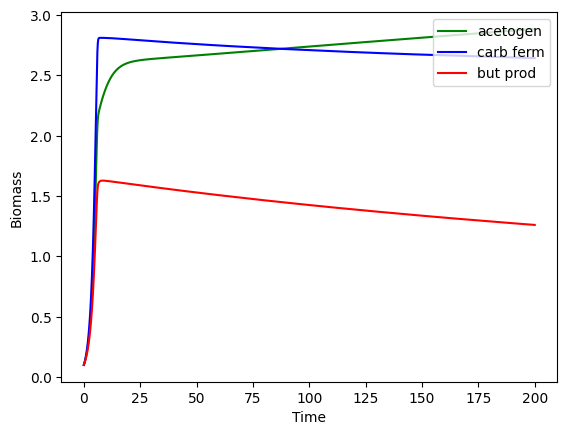

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[8], color='g', label='acetogen')
ax.plot(solution.t, solution.y[9], color='b', label='carb ferm')
ax.plot(solution.t, solution.y[10], color='r', label='but prod')
ax.set_ylabel('Biomass')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
#plt.savefig('/home/daniel_garza/plots/dFBA_biomass.png', dpi=300)
plt.show()

**Step 7**: plot the results for the metabolites

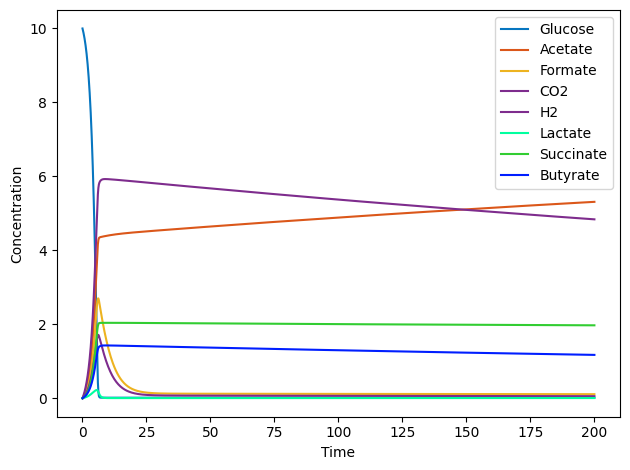

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[0], color='#0776c0', label='Glucose')

ax.plot(solution.t, solution.y[4], color='#db571a', label='Acetate')

ax.plot(solution.t, solution.y[1], color='#edb320', label='Formate')

ax.plot(solution.t, solution.y[2], color='#7e2c8d', label='CO2')
ax.plot(solution.t, solution.y[3], color='#7e2c8d', label='H2')

ax.plot(solution.t, solution.y[5], color='#00ff9f', label='Lactate')
ax.plot(solution.t, solution.y[6], color='#32CD32', label='Succinate')
ax.plot(solution.t, solution.y[7], color='#001eff', label='Butyrate')


ax.set_ylabel('Concentration')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('/home/daniel_garza/plots/dFBA_concentrations.png', dpi=300)
plt.show()
